This notebook will do supervised learning on 50 categories of images.

I'll use k-fold validation on the training data. We will also output the features to a text file to get them back. 

### Import

In [45]:
# Import all of the necessary files

## Non sklearn 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
# Set seaborn plotting styles for prettiness
sns.set(style="white")
sns.set_context("poster")

## skimage
# io
from skimage import io

## sklearn
# For random forest
from sklearn.ensemble import RandomForestClassifier
# For splitting the data
from sklearn.model_selection import train_test_split
# For confusion matrix
from sklearn import metrics
# For cross validation
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation # This seems to be deprevated but if it works I'm going to use it.
# To grayscale
from skimage.color import rgb2gray
# For corners:
from skimage.feature import corner_harris, corner_peaks
# Gradient (DAISY)
#from skimage.feature import daisy
# HOG
from skimage.feature import hog
# Blobs:
from skimage.feature import blob_doh

/Users/micbru/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Define all of the feature extraction and correlation

In [2]:
# Define a correlation so I don't have to write it every time:
def corr(x,y):
    corr_arr = np.corrcoef(x.flatten(),y.flatten())
    return corr_arr[0,1]

# Define one funtion to run on start up that has all features.
def feature_extraction(image):
    '''
    Extract features from the image. Return the result of each feature.
    '''
### Get useful features:    
    # Get grayscale image:
    gray = rgb2gray(image)
    
### Simple tests:
    # Mean
    mean = np.mean(image)
    
    # Variance
    var = np.var(image)
    
### Tests related to size:
    # Ratio
    # "length"
    l = image.shape[1]
    # "Height"
    h = image.shape[0]
    ratio = h/l
    
    # Cross correlation of left and right:
    lr_corr = corr(gray,np.roll(gray,int(l/2),1))
    # Cross correlation of bottom and top:
    bt_corr = corr(gray,np.roll(gray,int(h/2),0))
    
### Tests related to colour. Note that here we need to check if the image is grayscale. If it is just return mean.
    # Colour
    if (len(image.shape) == 3):
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        
        red = np.mean(r)
        r_var = np.var(r)
        
        green = np.mean(g)
        g_var = np.var(g)
        
        blue = np.mean(b)
        b_var = np.var(b)
                   
        rg_corr = corr(r,g)
        rb_corr = corr(r,b)
        gb_corr = corr(g,b)
    else:
        red = mean
        r_var = var
        green = mean
        g_var = var
        blue = mean
        b_var = var
        rg_corr = 1.
        rb_corr = 1.
        gb_corr = 1.
    
### Corner detection functions:
    ch = corner_harris(gray)
    # Corners
    corner_mean = np.mean(np.abs(ch))
    # Corner count
    corner_count = len(corner_peaks(ch))
    
### Blob detection:
    blobs = blob_doh(gray, max_sigma=10, threshold=.01)
    if (len(blobs) == 0):
        blob_mean = 0
        blob_var = 0
        blob_n = 0
    else:
        # Mean of blob size
        blob_mean = np.mean(blobs[:,2])
        # Variance of blob size
        blob_var = np.var(blobs[:,2])
        # Number of blobs
        blob_n = len(blobs)
    
### Gradients:
    grad, hog_vis = hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), block_norm = 'L2-Hys', visualise = True)
    # Mean of gradients
    hog_mean = np.mean(grad)
    # Var of gradients
    hog_var = np.var(grad)
    # Ratio of non zero gradients. I hope this will help with photos that have nothing going on.
    hog_r = np.count_nonzero(grad)/len(grad)
    
### Other correlations:
    # Correlation of corners and gradients:
    cg_corr = corr(np.abs(ch),hog_vis)
    
    return [mean, var, ratio, lr_corr, bt_corr,
            red, r_var, green, g_var, blue, b_var, rg_corr, rb_corr, gb_corr,
            corner_mean, corner_count,
            blob_mean, blob_var, blob_n,
            hog_mean, hog_var, hog_r,
            cg_corr]

### Define random forest test and a method for quantifying how useful it is

In [15]:
def rf_test(features,labels,categories,n_est = 10, size = 0.2):
    '''
    Run a random forest classifier given a set of features with lavels for each one.
    n_est = 10 by default but can be increased to probably make a better test.
    Print out the True and Predicted class, as well as the total accuracy.
    The accuracy should hopefully be better than random guessing (1/50) and better than just guessing airplane (~1/8)
    (Just because this test set has many airplanes)
    '''
    # Divide the data into testing and training data.
    X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=size, random_state=42)

    # instantiate classifier object
    classifier = RandomForestClassifier(n_est) # n_estimators is just the number of trees. Higher takes longer but is better.

    # fit the classification model on training set
    rf = classifier.fit(X_train, Y_train)

    # make predictions for testing set
    pred = classifier.predict(X_test)
    
    # Sort alphabetically before printing to make it prettier:
    # Have to get arguments so we can also sort pred.
    sort_indices = np.argsort(Y_test)
    Y_test.sort()
    pred = pred[sort_indices]

    print("{:20} {:20} {:1}".format('True Class','Predicted class', 'Correct?'))
    print('')
    [print('{:20} {:20} {:1}'.format(Y_test[i], pred[i], Y_test[i]==pred[i])) for i in range(len(Y_test))]
    print('')
    
    # Plot the confusion matrix:
    plot_confusion_matrix(Y_test, pred, categories, normalize=True, title='Confusion matrix', cmap=plt.cm.viridis)
    
    # Plot feature importance:
    f_importance(rf)
    
    # Total accuracy
    correct = 0
    for i in range(len(pred)):
        if(Y_test[i] == pred[i]):
            correct += 1
    print('')
    print("Total Accuracy")
    print(correct/len(Y_test))

In [18]:
# Make a function to plot the confusion matrix:
def plot_confusion_matrix(y_test, y_pred, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    """
            
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Plot
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
# Try out cross validation:
def cross_val(n_est,x,y,n):
    '''
    n_est: Number of estimators in random forest classifier
    x: The features
    Y: The labels
    n: Number of cross validations
    '''
    # Use the same classifier as above:
    classifier = RandomForestClassifier(n_est)
    
    # Get the scores by cross validation
    scores = cross_val_score(classifier, x, y, cv=cross_validation.KFold(len(y),n,shuffle=True,random_state=1), n_jobs=-1)
    
    # Print out the mean and standard deviation
    print("mean: {:3f}, stdev: {:3f}".format(np.mean(scores), np.std(scores)))


In [41]:
# Find feature importance:
def f_importance(rf):
    # Read in random forest classifier as rf.
    feature_importances = rf.feature_importances_
    # This list is from above and must be edited if we change the features
    feature_list = ['mean', 'var', 'ratio', 'lr_corr', 'bt_corr',
            'red', 'r_var', 'green', 'g_var', 'blue', 'b_var', 'rg_corr', 'rb_corr', 'gb_corr',
            'corner_mean', 'corner_count',
            'blob_mean', 'blob_var', 'blob_n',
            'hog_mean', 'hog_var', 'hog_r',
            'cg_corr']
    # Sort to most important:
    sort_ind = np.argsort(feature_importances)
    feature_importances.sort()
    # Print in opposite order
    f_len = len(feature_importances)
    [print('{:10} {:5}'.format(feature_list[sort_ind[f_len-1-i]], feature_importances[f_len-1-i])) for i in range(f_len)]
    

### Define  function for homework
This will use all the features and train on a new set.

In [ ]:
def run_final_classifier(path):
    '''
    This function will take a path that contains .jpg images, and predicts the class of each one.
    '''
    # First train on all available data:
    X_train = features
    Y_train = labels
    
    # instantiate classifier object
    classifier = RandomForestClassifier(n_est) # n_estimators is just the number of trees. Higher takes longer but is better.

    # fit the classification model on training set
    rf = classifier.fit(X_train, Y_train)
    
    # Load in all the files as a list. 
    images = io.ImageCollection(path+'/*.png')
    
    # Extract features of those images:
    X_test = []
    for img in images:
        f = feature_extraction(img)
        X_test.append(f)

    # make predictions for testing set
    pred = classifier.predict(X_test)
    
    # Print out results:
    print("{:20} {:20}".format('Filename','Predicted class'))
    print('----------------------------------------')
    [print('{:20} {:20}'.format(images[i], pred[i])) for i in range(len(X_test))]
    

### Load in all the categories

In [5]:
# Load in all the categories as a list. Ignore files that have . at the beginning:
categories = [name for name in os.listdir("./50_categories/") if name[0] != '.']

# Load in the images:
images = {}
for name in categories:
    images.update({name: io.ImageCollection('./50_categories/'+name+'/*')})

### Testing new functions
Please ignore this for grading!!!

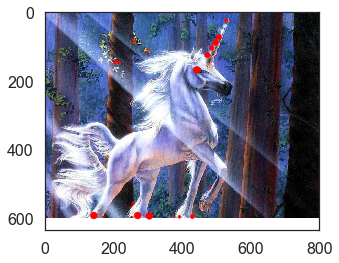

(26, 3) (600, 800) (56448,) (600, 800)
0.016763326743 0.0477725272587
0.301591016551


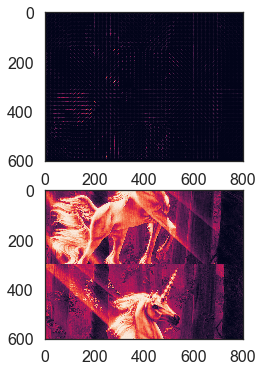

In [54]:
# This cell is to play around with the images before I run feature extraction, if necessary. Also pretty triceratopses.
# Please ignore this for grading purposes.
imgt = images['unicorn'][0]
blobs_doh = blob_doh(rgb2gray(imgt), max_sigma=10, threshold=.01)
fig, ax = plt.subplots()
ax.imshow(imgt)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='r')
    ax.add_patch(c)
ax.plot() 
plt.show()
ch = corner_harris(rgb2gray(imgt))
grad, hog_image = hog(rgb2gray(imgt), orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), block_norm = 'L2-Hys',visualise=True)
print(blobs_doh.shape,ch.shape,grad.shape,hog_image.shape)
fig2, (ax2,ax3) = plt.subplots(2,figsize=(8,6))
ax2.imshow(hog_image)
ax3.imshow(ch)
print(corr(ch,hog_image),corr(np.abs(ch),hog_image))
plt.imshow(np.roll(rgb2gray(imgt),300,0))
print(corr(rgb2gray(imgt),np.roll(rgb2gray(imgt),300,0)))

### Extract all the features and run the random forest classifier

In [ ]:
# Reload features if they exist to save time:
features = np.loadtxt("features.txt")
labels = np.loadtxt("labels.txt")

In [6]:
# For each image extract features and save the label.
# Do not run this cell if we already have the features saved to file.
# Sorry this takes a very long time. I wanted to parallelize but didn't do that homework and couldn't get it working in time... 

# First start empty lists.
features = []
labels = []
for l in categories:
    print(l)
    for img in images[l]:
        # Extract features
        f = feature_extraction(img)
        features.append(f)
        labels.append(l)

# Save features to file:
np.savetxt("features.txt",features)
np.savetxt('labels.txt',labels,fmt='%s') # Need to save using strings.

airplanes
bat
bear
blimp
camel
comet
conch
cormorant
crab
dog
dolphin
duck
elephant
elk
frog
galaxy
giraffe
goat
goldfish
goose
gorilla
helicopter
horse
hot-air-balloon
hummingbird
iguana
kangaroo
killer-whale
leopards
llama
mars
mussels
octopus
ostrich
owl
penguin
porcupine
raccoon
saturn
skunk
snail
snake
speed-boat
starfish
swan
teddy-bear
toad
triceratops
unicorn
zebra


TypeError: Mismatch between array dtype ('<U15') and format specifier ('%.18e')

In [ ]:
# Run the random forest classifier, print out total percentage and confusion matrix.
rf_test(features,labels,categories,n_est = 200, size =0.1)
# A note on n_est: I played around with this a bit and found it to be better as it gets large.
# The improvement gets smaller so I just chose 200.

In [49]:
# Show n_est:
# n is 10, just to have a reasonable cross validation sample.
[print(cross_val(i,features,labels,10)) for i in [50,100,150,200,250]]

mean: 0.286536, stdev: 0.019941
None
mean: 0.296202, stdev: 0.022894
None
mean: 0.304215, stdev: 0.025515
None
mean: 0.309159, stdev: 0.022301
None
mean: 0.309868, stdev: 0.022320
None


[None, None, None, None, None]